In [1]:
# get permission to access drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


1. Train a word embedding (Word2Vec, GloVe, ELMo, BERT, etc) on your corpus, once with a small window (e.g. 2) and again with a long window (e.g. 16). What do you expect to change for the different window sizes? Pick a sample of 100 words and visualize them in two dimensions, to demonstrate the difference between the models.

In [2]:
# The following has been copied from problem sets 1 and 2
import pandas as pd
import numpy as np
datapath = '/content/gdrive/My Drive/Colab Notebooks/data/'
cases = pd.read_csv(datapath + 'cases_metadata.csv')
cases = cases.dropna(subset=['log_cites'])
no_of_cases = 1000
random_indices = list(np.random.choice(cases.shape[0], no_of_cases, replace = False))
caseids = list(cases.iloc[random_indices]["caseid"])

In [3]:
# load the cases
import glob

text = {}
casepath = datapath + 'cases/'
for caseid in caseids:
    names = glob.glob(casepath + "*_" + caseid + ".txt")  # try to find file with particular caseid
    if len(names) > 0:  # if file exists
        filename = names[0]
        file = open(filename, mode = 'r')
        case = filename[len(casepath):-len('.txt')]  # keep year_caseid
        text[case] = file.read()
        file.close()

In [4]:
import spacy
nlp = spacy.load('en', disable=['ner'])
docs = {}
for case in text:
    docs[case] = nlp(text[case])

In [5]:
words = {}
for case in docs:
    words[case] = [token for token in docs[case] if token.is_alpha]

In [6]:
# save part of speech tags for later
pos = {str(word).lower(): word.pos_ for word in words[case] for case in words}

In [7]:
from string import punctuation
translator = str.maketrans('', '', punctuation) 

##################################################
# - we do not remove stopwords
# - we do not stem the words, since this might change the part of speech tag (we need the adjectives later on)
##################################################
def normalize_text(doc):
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        lower = sent.lower()  # all lower case
        nopunc = lower.translate(translator)  # remove punctuation
        words = nopunc.split()  # split into tokens
        no_numbers = [w if not w.isdigit() else '#' for w in words]  # normalize numbers
        tokens += no_numbers  # add to list of tokens for this speech
    return tokens

In [8]:
normalized = {}
for case in docs:
    normalized[case] = normalize_text(docs[case])

In [9]:
# From this point onwards, the code is new, i.e. not contained in previous problem sets
sentences = [str(sent).split() for sent in normalized[case] for case in normalized]

In [10]:
from gensim.models import Word2Vec
workers = 8
size = 300
min_count = 5

small_window = Word2Vec(sentences, workers=workers, size=size, min_count=min_count, window=2)
large_window = Word2Vec(sentences, workers=workers, size=size, min_count=min_count, window=16)
small_window.init_sims(replace=True)
large_window.init_sims(replace=True)

# For the embedding with the small window size, we expect functionally similar words to be closer in the embedding space; 
# for the embedding with the large window size, we expect related words to be closer in the embedding space. 

In [11]:
small_sample = np.random.choice(list(small_window.wv.vocab), 100, replace=False)
large_sample = np.random.choice(list(large_window.wv.vocab), 100, replace=False)

In [12]:
from sklearn.manifold import TSNE
small_full_embeddings = small_window[small_sample]
large_full_embeddings = large_window[large_sample]
tsne = TSNE(n_components=2)
small_projected_embeddings = tsne.fit_transform(small_full_embeddings)
large_projected_embeddings = tsne.fit_transform(large_full_embeddings)
small_df = pd.DataFrame(small_projected_embeddings, index=small_sample, columns=['x', 'y'])
large_df = pd.DataFrame(large_projected_embeddings, index=large_sample, columns=['x', 'y'])

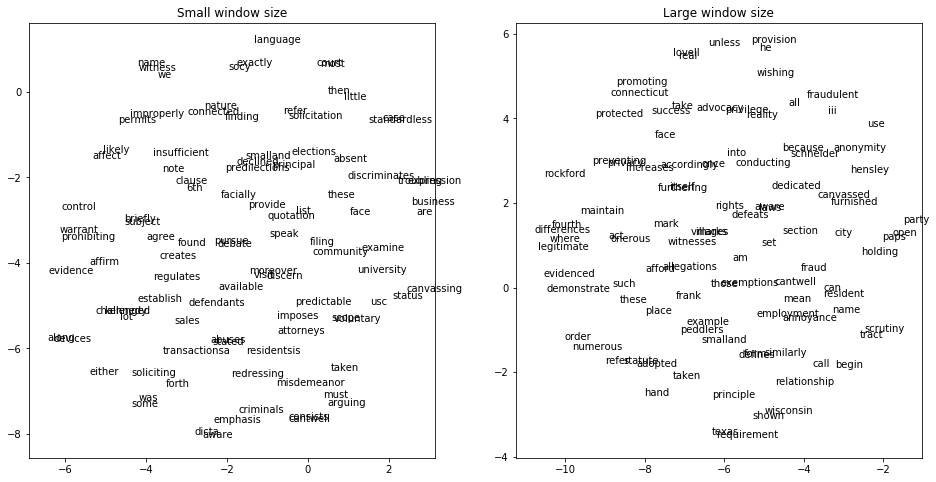

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 8))
small_ax = fig.add_subplot(1, 2, 1)
large_ax = fig.add_subplot(1, 2, 2)
small_ax.set_title('Small window size')
large_ax.set_title('Large window size')
small_ax.scatter(small_df['x'], small_df['y'], alpha=0)
large_ax.scatter(large_df['x'], large_df['y'], alpha=0)
for (small_word, small_pos), (large_word, large_pos) in zip(small_df.iterrows(), large_df.iterrows()):
    small_ax.annotate(small_word, small_pos)
    large_ax.annotate(large_word, large_pos)

2. Train separate word embeddings for Republican and Democrat judges. Use your word embeddings to list the adjectives most associated with a social group or concept of your choice, and analyze differences by judge party.

In [14]:
democrat_sentences, republican_sentences = [], []
for case in normalized:
    for sent in normalized[case]:
        if any(cases.loc[cases['caseid'] == case[5:len(case)]].x_republican.astype(bool)):
            republican_sentences.append(str(sent).split())
        else:
            democrat_sentences.append(str(sent).split())

In [15]:
window = 10
republican_embedding = Word2Vec(republican_sentences, workers=workers, size=size, min_count=min_count, window=window)
democrat_embedding = Word2Vec(democrat_sentences, workers=workers, size=size, min_count=min_count, window=window)
republican_embedding.init_sims(replace=True)
democrat_embedding.init_sims(replace=True)

In [16]:
republican_adjectives = [pair[0] for pair in republican_embedding.wv.most_similar('black', topn=1500) if pair[0] in pos and pos[pair[0]] == 'ADJ']
republican_adjectives

['broad',
 'narrow',
 'its',
 'patented',
 'guilty',
 'which',
 'new',
 'unfair',
 'able',
 'original',
 'other',
 'only',
 'different',
 'prior',
 'former',
 'valid',
 'middle',
 'general',
 'lower',
 'first',
 'such',
 'second',
 'vague',
 'vertical',
 'same',
 'his',
 'our',
 'apparent',
 'further',
 'considerable',
 'inconsistent']

In [17]:
democrat_adjectives = [pair[0] for pair in democrat_embedding.wv.most_similar('black', topn=1500) if pair[0] in pos and pos[pair[0]] == 'ADJ']
democrat_adjectives

['broad',
 'narrow',
 'its',
 'guilty',
 'which',
 'new',
 'unfair',
 'able',
 'original',
 'other',
 'only',
 'different',
 'prior',
 'former',
 'valid',
 'middle',
 'general',
 'lower',
 'first',
 'such',
 'second',
 'vague',
 'same',
 'his',
 'our',
 'apparent']

In [18]:
[adj for adj in republican_adjectives if adj not in democrat_adjectives]

['patented', 'vertical', 'further', 'considerable', 'inconsistent']

In [19]:
[adj for adj in democrat_adjectives if adj not in republican_adjectives]

# We do not see major differences between republican and democrat adjectives associated with 'black'. 
# This could be due to two reasons: (1) The word 'black' as a color has a relatively neutral meaning; 
# (2) The data set on which the embeddings were trained was too small to see significant differences. 

[]

3. Implement one of the causal inference methods from Lecture 12 (choose one of the following options):

a. Look at the effect of text features on citations or reversal (Fong and Grimmer 2016, Hartford et al 2017, or Wang and Blei 2018)

**b. Look at the effect of political party on citations or reversal holding text features constant (Roberts-Stewart-Nielsen 2018 matching method or Chernozhukov et al 2017 double ML method).**

c. Look at heterogeneous effects of political party on citations or reversal depending on text features (Wager and Athey 2017).


In [20]:
# As text features, we again use frequencies over trigrams ending in a noun. 
# The following has been taken from problem sets 1 and 2. 

import nltk
from nltk import trigrams
ends_in_noun = {}
for case in normalized:
    trigrams = list(nltk.trigrams(normalized[case]))
    ends_in_noun[case] = []
    for trigram in trigrams:
        string = " ".join(trigram)
        if trigram[2] in pos and pos[trigram[2]] == 'NOUN':
            ends_in_noun[case].append(string)

In [21]:
from collections import Counter
frequencies = {}
for case in ends_in_noun:
    to_count = (trigram for trigram in ends_in_noun[case])
    frequencies[case] = Counter(to_count).most_common()

In [22]:
# features: the trigrams that are contained in all documents, plus the top-K most common ones in any of the documents
import math
features = set()
no_of_most_common_trigrams = math.ceil(1000 / no_of_cases)  # this is the K we choose for top-K
intersection = set(map(lambda x: x[0], list(frequencies.values())[0]))  # initially contains all trigrams of arbitrary document
for case in frequencies:
    for trigram in set(map(lambda x: x[0], frequencies[case][0:min(no_of_most_common_trigrams, len(frequencies[case]))])):
        features.add(trigram)
    intersection = intersection.intersection(set(map(lambda x: x[0], frequencies[case])))
features = list(features.union(intersection))

In [23]:
df = pd.DataFrame(columns = ["case"] + features)
for case in frequencies:
    data = {}
    data["case"] = case[5:len(case)]  # now keeping only case id and throwing away year
    for feature in features:
        if feature in dict(frequencies[case]):
            data[feature] = dict(frequencies[case])[feature]
        else:
            data[feature] = 0
    df = df.append(data, ignore_index = True)

for feature in features:
    df[feature] /= np.sqrt(np.var(df[feature]))  # standardize to variance 1

In [24]:
df = df.join(pd.read_csv(datapath + 'cases_metadata.csv').set_index('caseid'), on='case')

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
# We choose to do option b: we look at the effect of the political party (T) on reversal (Y) holding text features (A) constant. 

df = df.dropna(how='any')
n = df.count()[0]

# split the dataset in two, as needs to be done in the double ML method
shuffle = np.arange(n)
np.random.shuffle(shuffle)
first_half = shuffle[0:math.floor(n/2-1)]
second_half = shuffle[math.floor(n/2):(n-1)]

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def get_residuals(x_train, y_train, x_test, y_test):
    grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}
    grid_search = GridSearchCV(LogisticRegression(), grid, cv=10)         
    grid_search.fit(x_train, y_train)

    logreg = LogisticRegression(penalty = grid_search.best_params_['penalty'], C = grid_search.best_params_['C']).fit(x_train, y_train)
    predictions = logreg.predict(x_test)
    residuals = predictions - y_test
  
    return residuals

In [28]:
import statsmodels.api as sm

def get_theta(Y_tilde, T_tilde):
    T_tilde = sm.add_constant(T_tilde)
    linreg = sm.OLS(Y_tilde, T_tilde)
    theta = linreg.fit().params
    return theta

In [29]:
A_a = df.loc[first_half, features].dropna()
Y_a = df.case_reversed[first_half].dropna()
T_a = df.x_republican[first_half].dropna()

A_b = df.loc[second_half, features].dropna()
Y_b = df.case_reversed[second_half].dropna()
T_b = df.x_republican[second_half].dropna()

residuals_Y1 = get_residuals(A_a, Y_a, A_b, Y_b)
residuals_T1 = get_residuals(A_a, T_a, A_b, T_b)
residuals_Y2 = get_residuals(A_b, Y_b, A_a, Y_a)
residuals_T2 = get_residuals(A_b, T_b, A_a, T_a)

theta_a = get_theta(residuals_Y1, residuals_T1)
theta_b = get_theta(residuals_Y2, residuals_T2)
theta = (theta_a + theta_b) / 2
print(theta)

const           0.311515
x_republican    0.037134
dtype: float64


In [30]:
# Since the coefficient corresponding to political party is positive, 
# we could say that being republican has a positive effect on reversal of a case. 
# However, this could also happen due to chance, 
# so perhaps additional tests for statistical significance need to be done before drawing conclusions. 